In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, r2_score

from task3_1 import preprocess_star_dataset, preprocess_gwp_dataset

## Star Dataset

In [2]:
def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(confusion_matrix, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(j, i, confusion_matrix[i, j],
                    ha="center", va="center",
                    color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black")
    plt.show()

In [3]:
def evaluate_classification_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(f'Accuracy: {model.score(x_test, y_test)}')
    print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1-score: {f1_score(y_test, y_pred, average="weighted")}')
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_matrix, ['GALAXY', 'QSO', 'STAR'])

In [4]:
star_X, star_Y = preprocess_star_dataset('datasets/star_assessment.csv')

#### Splitting into train and test sets

In [5]:
star_x_train, star_x_test, star_y_train, star_y_test = train_test_split(star_X, star_Y, test_size=0.2, stratify=star_Y)

#### Train a baseline SVM classifier

In [6]:
svc = SVC()
svc.fit(star_x_train, star_y_train)

SVC()

Accuracy: 0.965543421129475
Precision: 0.9654506801034961
Recall: 0.965543421129475
F1-score: 0.9649184689441443


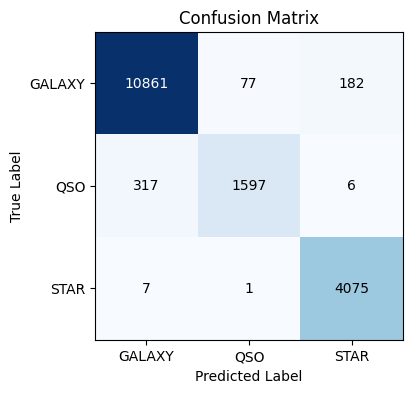

In [7]:
evaluate_classification_model(svc, star_x_test, star_y_test)

#### Perform hyperparameter tuning

In [8]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100]
}

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(star_x_train, star_y_train)

In [9]:
grid_search.best_params_

## GWP Dataset

In [12]:
def plot_actual_predicted(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(y_test[:10], 'o', label='Actual')
    ax.plot(y_pred[:10], 'o', label='Prediction')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.xlabel('Index of sample')
    plt.ylabel('Actual/Predicted value of the target')
    plt.show()

In [13]:
def evaluate_regression_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(f'R^2 Score: {r2_score(y_test, y_pred)}')
    print(f'RMSE: {np.sqrt(np.mean((y_test - y_pred) ** 2))}')
    plot_actual_predicted(y_test, y_pred)

In [4]:
gwp_X, gwp_Y = preprocess_gwp_dataset('datasets/gwp_assessment.csv')

#### Splitting into train and test sets

In [6]:
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = train_test_split(gwp_X, gwp_Y, test_size=0.2)

In [7]:
lr = LinearRegression()
lr.fit(gwp_x_train, gwp_y_train)

LinearRegression()

R^2 Score: 0.1544864543436899
RMSE: 0.15487104734799617


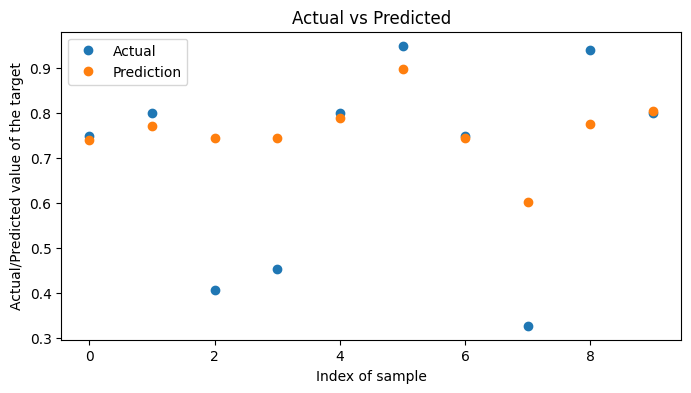

In [14]:
evaluate_regression_model(lr, gwp_x_test, gwp_y_test)

## Markdown Question

*Is Linear Regression a good model to use for the star dataset? Justify your answer.*

Linear regression models assume a linear relationship between the features and the target variable, which isn't true in the case of many classification problems. In the star dataset the target variable is categorical, namely `galaxy`, `qso` and `star`, meaning it is suited to be a classification task. Therefore, linear regression isn't a suitable model to use for this dataset, as there may not be a linear relationship between the features and the target. Additionally, using a linear regression model for the star dataset may result in predictions being made that don't fall into any of the three categories, making the predictions harder to interpret (and in certain cases, meaningless). Another reason why they shouldn't be used is that evaluation metrics commonly used for regression models, such as RMSE, are not suitable to be used for classification tasks, which use other metrics, including accuracy and F1-score. Finally, linear regression models are more sensitive to outliers than those suited to classification, which may result in the model being less accurate than a classification model.